In [1]:
import os
import copy
import time
import asyncio
import warnings
import logging

from pathlib import Path

import numpy as np
from astropy.io import fits

from scipy import ndimage
from scipy.signal import medfilt
from scipy.ndimage.filters import gaussian_filter
from astropy.modeling import models, fitting


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [7, 6]

#Import CWFS package
from lsst import cwfs
from lsst.cwfs.instrument import Instrument
from lsst.cwfs.algorithm import Algorithm
from lsst.cwfs.image import Image, readFile, aperture2image, showProjection
import lsst.cwfs.plots as plots

import wget
from lsst.ts import salobj

%matplotlib inline

In [2]:
cam = salobj.Remote(salobj.Domain(), "GenericCamera", 1)

In [3]:
await cam.start_task

In [4]:
zern = []
dz_vec = [0.5, 0.7, 0.9, 1.1, 1.3, 1.5]

Waiting intra image
1579924167-16Pup_intra-0-1
1579924216-16Pup_extra-0-1
1579924167-16Pup_intra-0-1.fits
1579924216-16Pup_extra-0-1.fits
2 3
Creating stamps of centroid [y,x] = [370,609] with a side length of 150 pixels
Offset should be :20.5 [mm] at the focus, 0.5 [mm] at the hexapod
Offset in file is :20.5 [mm] at the focus
pixelSize should be: 1.44e-05


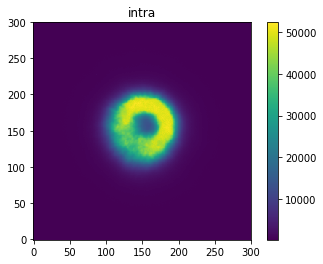

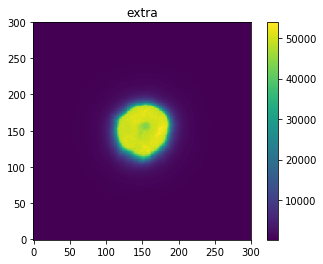

Extra-focal filename: 1579924216-16Pup_extra-0-1.fits
Intra-focal filename: 1579924167-16Pup_intra-0-1.fits


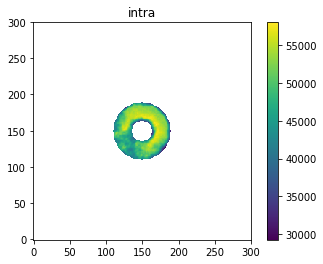

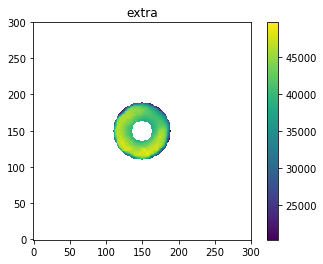

[-191.40271886   87.37068443   16.01153738   14.75869529   11.8456627
  -33.90329815   17.77569872   13.00752371   -0.74032462   -6.06379519
    2.8141552    -3.81071244    1.18856014    0.90442976   -0.70272222
    0.78579421   -4.02598245    2.97650858   -3.26629855]


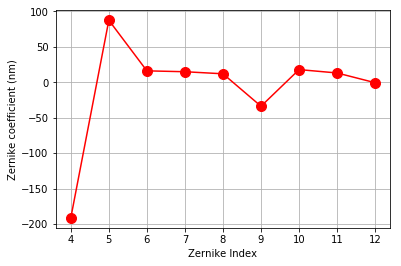

RemoteEvent(GenericCamera, 1, logMessage) falling behind; read 76 messages


Waiting intra image


RemoteEvent(GenericCamera, 1, heartbeat) falling behind; read 70 messages


CancelledError: 

In [5]:
for i in range(6):
    print("================================================================================")
    print("Waiting intra image")
    cam.evt_endReadout.flush()
    intra_endron = await cam.evt_endReadout.next(flush=False)
    if "intra" not in intra_endron.imageName:
        print(f"Got {intra_endron.imageName}. Not an intra image... skipping")
        continue
    print(intra_endron.imageName)

    extra_endron = await cam.evt_endReadout.next(flush=False, timeout=120)
    print(extra_endron.imageName)

    intra_wget_url = 'http://139.229.170.216:8000/data/'+intra_endron.imageName+'.fits'
    extra_wget_url = 'http://139.229.170.216:8000/data/'+extra_endron.imageName+'.fits'
    download_done = False
    while not download_done:
        try:
            intra_fname = wget.download(intra_wget_url)
        except Exception as e:
            print(f"Error downloading {intra_wget_url}. waiting 5s and trying again.")
            await asyncio.sleep(5.)
        else:
            download_done = True
    print(f"============")
    print(f'{intra_fname}')

    download_done = False
    while not download_done:
        try:
            extra_fname = wget.download(extra_wget_url)
        except Exception as e:
            print(f"Error downloading {intra_wget_url}. waiting 5s and trying again.")
            await asyncio.sleep(5.)
        else:
            download_done = True
            
    print(f'{extra_fname}')
    print(f"============")

    # Open fits files, note you can start here if your files exist already

    #intra_fname='I1_intra_20190908.fits'
    intra_exp=(fits.open(intra_fname))[0].data

    #extra_fname='I2_extra_20190908.fits'
    extra_exp=(fits.open(extra_fname))[0].data

    # Show images added together to estimate centroid
    plt.imshow(intra_exp+extra_exp)

    # Define the image it will use to perform final center
    im_shape=intra_exp.shape
    side=300
    # Set to False to declare centroid manually!
    if True:
        im= (intra_exp+extra_exp)
        im_filtered = medfilt(im,[5,5])
        im_filtered -= int(np.median(im_filtered))
        mean = np.mean(im_filtered)
    #     im_filtered[im_filtered < mean] = 0.
    #     im_filtered[im_filtered > mean] = 1.
        # iter 1
        ceny, cenx = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
        # iter 2
        intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
        extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]
        im= (intra_square+extra_square)
        im_filtered = medfilt(im,[5,5])
        im_filtered -= int(np.median(im_filtered))
        mean = np.mean(im_filtered)
        im_filtered[im_filtered < mean] = 0.
        im_filtered[im_filtered > mean] = 1.
        # iter 1
        cy2, cx2 = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
        print(cy2-side, cx2-side)    
        ceny += (cy2-side)
        cenx += (cx2-side)
    else:
        # Manually declare where the center is
        ceny=350 #round(im_shape[0]/2)
        cenx=450 # round(im_shape[1]/2)
    side=150 # side length of image
    print('Creating stamps of centroid [y,x] = [{},{}] with a side length of {} pixels'.format(ceny,cenx,side))
    im_shape=intra_exp.shape
    intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
    extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]

    #Create object for CWFS code
    # Select where your object is, but ours will be on-axis
    fieldXY = [0.0,0.0]

    # I1/I2 get modified down below, so reset here
    I1 = None; I2=None
    I1 = Image(intra_square, fieldXY, Image.INTRA)
    I2 = Image(extra_square, fieldXY, Image.EXTRA)

    # Declare instrument
    inst=Instrument('auxtel',I1.sizeinPix) # example
    inst.offset = dz_vec[i]*0.041
    hex_to_focus_scale = 41.0
    offset=0.5 *hex_to_focus_scale # [mm] multiply hexapod dz by magnification factor
    pixelsize = 3.6e-6*4 # 4 is the binning
    # FIXME: put an assertion here and calculate binning above based on change in image size, also pull offset from filename!

    print('Offset should be :{} [mm] at the focus, {} [mm] at the hexapod'.format(offset, offset/hex_to_focus_scale))
    print('Offset in file is :{} [mm] at the focus'.format(1e3*inst.offset))
    print('pixelSize should be: {}'.format(pixelsize))

    #declare algorithm
    # declare algorithm - exponential solver.
    algo=Algorithm('exp',inst,1) # example - but only want 11 Zernikes (Num_of_Zernikes)


    # Plot images
    plots.plotImage(I1.image,'intra') 
    #plots.plotImage(I_focus.image,'focus')
    plots.plotImage(I2.image,'extra')
    print('Extra-focal filename: {}'.format(extra_fname))
    print('Intra-focal filename: {}'.format(intra_fname))

    algo.runIt(inst,I1,I2,'onAxis')
    plots.plotImage(I1.image,'intra', mask=algo.pMask) 
    #plots.plotImage(I_focus.image,'focus')
    plots.plotImage(I2.image,'extra', mask=algo.pMask)    
    print(algo.zer4UpNm)
    plots.plotZer(algo.zer4UpNm[0:9],'nm')
    zern.append(algo.zer4UpNm[0:9])

Waiting intra image
1579924627-16Pup_intra-0-1
1579924676-16Pup_extra-0-1
1579924627-16Pup_intra-0-1.fits
1579924676-16Pup_extra-0-1.fits
5 3
Creating stamps of centroid [y,x] = [317,585] with a side length of 150 pixels
Offset should be :20.5 [mm] at the focus, 0.5 [mm] at the hexapod
Offset in file is :20.5 [mm] at the focus
pixelSize should be: 1.44e-05


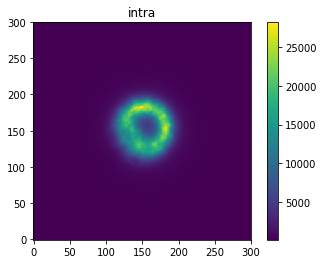

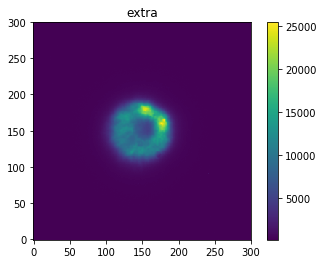

Extra-focal filename: 1579924676-16Pup_extra-0-1.fits
Intra-focal filename: 1579924627-16Pup_intra-0-1.fits


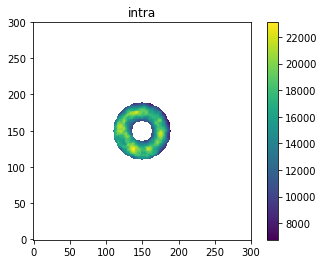

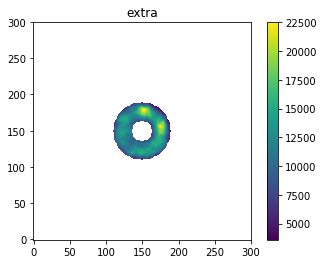

[ 11.67343028  69.18526159  77.06704462  49.71408814  37.03258309
 -21.69946966  -8.27806142   8.16894308  -3.39368404 -12.3452302
   3.87803733   4.52128612   1.45019628  -2.66216626   4.70907926
   0.51915493   1.33059566 -18.37198766  -3.09652269]


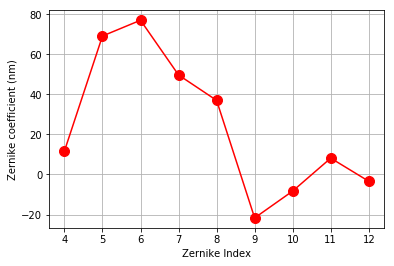

RemoteEvent(GenericCamera, 1, logMessage) falling behind; read 75 messages


Waiting intra image


RemoteEvent(GenericCamera, 1, heartbeat) falling behind; read 70 messages


1579924833-16Pup_intra-0-1
1579924883-16Pup_extra-0-1
1579924833-16Pup_intra-0-1.fits
1579924883-16Pup_extra-0-1.fits
8 4
Creating stamps of centroid [y,x] = [355,593] with a side length of 150 pixels
Offset should be :20.5 [mm] at the focus, 0.5 [mm] at the hexapod
Offset in file is :28.7 [mm] at the focus
pixelSize should be: 1.44e-05


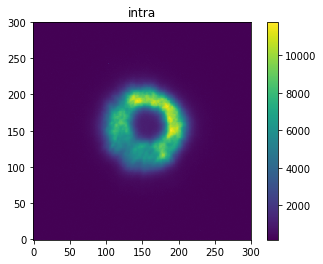

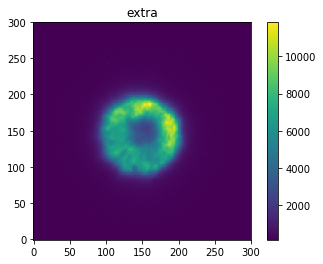

Extra-focal filename: 1579924883-16Pup_extra-0-1.fits
Intra-focal filename: 1579924833-16Pup_intra-0-1.fits


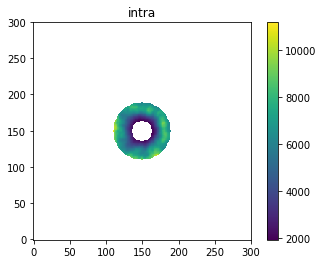

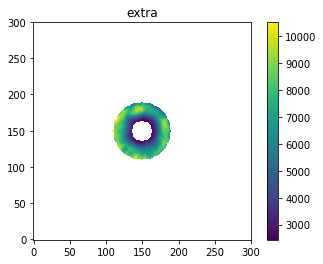

[-104.47770891   40.40196124   43.61351577  -25.83492204  -40.39759588
   25.80071769  -46.20048213   42.74478287    5.36188782   -7.87299905
   -6.20237549  -18.45260129   19.81160051   20.85076064    5.00811198
   -4.84788235   12.97561811  -14.323023     -7.60353888]


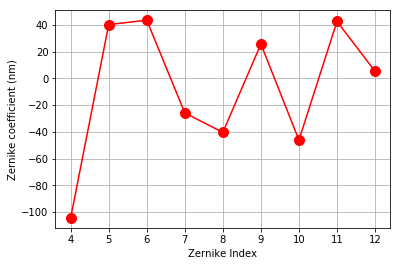

RemoteEvent(GenericCamera, 1, logMessage) falling behind; read 25 messages
RemoteEvent(GenericCamera, 1, heartbeat) falling behind; read 71 messages


Waiting intra image
1579924945-16Pup_intra-0-1
1579924993-16Pup_extra-0-1
1579924945-16Pup_intra-0-1.fits
1579924993-16Pup_extra-0-1.fits
8 5
Creating stamps of centroid [y,x] = [339,582] with a side length of 150 pixels
Offset should be :20.5 [mm] at the focus, 0.5 [mm] at the hexapod
Offset in file is :36.900000000000006 [mm] at the focus
pixelSize should be: 1.44e-05


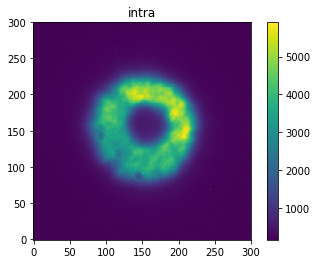

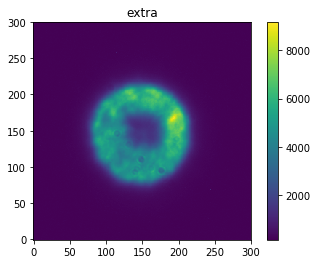

Extra-focal filename: 1579924993-16Pup_extra-0-1.fits
Intra-focal filename: 1579924945-16Pup_intra-0-1.fits


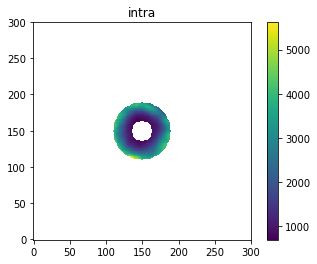

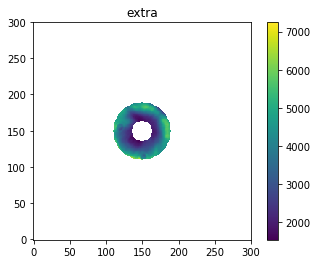

[  37.58205147   80.38980457  221.39801727 -260.6455648  -150.94971369
   85.39762426   73.03991867    7.65003306  -17.67374435   -4.54290648
   31.29525638   17.0897356    31.76715049   49.83966606   -9.19687219
   -3.9539488    -9.29815362  -31.45925739   -1.95902661]


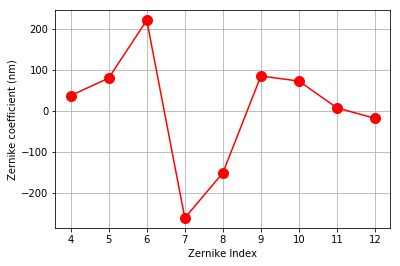

Waiting intra image


RemoteEvent(GenericCamera, 1, heartbeat) falling behind; read 72 messages


CancelledError: 

In [6]:
for i in range(6):
    print("================================================================================")
    print("Waiting intra image")
    cam.evt_endReadout.flush()
    intra_endron = await cam.evt_endReadout.next(flush=False)
    if "intra" not in intra_endron.imageName:
        print(f"Got {intra_endron.imageName}. Not an intra image... skipping")
        continue
    print(intra_endron.imageName)

    extra_endron = await cam.evt_endReadout.next(flush=False, timeout=120)
    print(extra_endron.imageName)

    intra_wget_url = 'http://139.229.170.216:8000/data/'+intra_endron.imageName+'.fits'
    extra_wget_url = 'http://139.229.170.216:8000/data/'+extra_endron.imageName+'.fits'
    download_done = False
    while not download_done:
        try:
            intra_fname = wget.download(intra_wget_url)
        except Exception as e:
            print(f"Error downloading {intra_wget_url}. waiting 5s and trying again.")
            await asyncio.sleep(5.)
        else:
            download_done = True
    print(f"============")
    print(f'{intra_fname}')

    download_done = False
    while not download_done:
        try:
            extra_fname = wget.download(extra_wget_url)
        except Exception as e:
            print(f"Error downloading {intra_wget_url}. waiting 5s and trying again.")
            await asyncio.sleep(5.)
        else:
            download_done = True
            
    print(f'{extra_fname}')
    print(f"============")

    # Open fits files, note you can start here if your files exist already

    #intra_fname='I1_intra_20190908.fits'
    intra_exp=(fits.open(intra_fname))[0].data

    #extra_fname='I2_extra_20190908.fits'
    extra_exp=(fits.open(extra_fname))[0].data

    # Show images added together to estimate centroid
    plt.imshow(intra_exp+extra_exp)

    # Define the image it will use to perform final center
    im_shape=intra_exp.shape
    side=300
    # Set to False to declare centroid manually!
    if True:
        im= (intra_exp+extra_exp)
        im_filtered = medfilt(im,[5,5])
        im_filtered -= int(np.median(im_filtered))
        mean = np.mean(im_filtered)
    #     im_filtered[im_filtered < mean] = 0.
    #     im_filtered[im_filtered > mean] = 1.
        # iter 1
        ceny, cenx = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
        # iter 2
        intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
        extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]
        im= (intra_square+extra_square)
        im_filtered = medfilt(im,[5,5])
        im_filtered -= int(np.median(im_filtered))
        mean = np.mean(im_filtered)
        im_filtered[im_filtered < mean] = 0.
        im_filtered[im_filtered > mean] = 1.
        # iter 1
        cy2, cx2 = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
        print(cy2-side, cx2-side)    
        ceny += (cy2-side)
        cenx += (cx2-side)
    else:
        # Manually declare where the center is
        ceny=350 #round(im_shape[0]/2)
        cenx=450 # round(im_shape[1]/2)
    side=150 # side length of image
    print('Creating stamps of centroid [y,x] = [{},{}] with a side length of {} pixels'.format(ceny,cenx,side))
    im_shape=intra_exp.shape
    intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
    extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]

    #Create object for CWFS code
    # Select where your object is, but ours will be on-axis
    fieldXY = [0.0,0.0]

    # I1/I2 get modified down below, so reset here
    I1 = None; I2=None
    I1 = Image(intra_square, fieldXY, Image.INTRA)
    I2 = Image(extra_square, fieldXY, Image.EXTRA)

    # Declare instrument
    inst=Instrument('auxtel',I1.sizeinPix) # example
    hex_to_focus_scale = 41.0
    offset=0.5 *hex_to_focus_scale # [mm] multiply hexapod dz by magnification factor
    pixelsize = 3.6e-6*4 # 4 is the binning
    # FIXME: put an assertion here and calculate binning above based on change in image size, also pull offset from filename!

    print('Offset should be :{} [mm] at the focus, {} [mm] at the hexapod'.format(offset, offset/hex_to_focus_scale))
    print('Offset in file is :{} [mm] at the focus'.format(1e3*inst.offset))
    print('pixelSize should be: {}'.format(pixelsize))

    #declare algorithm
    # declare algorithm - exponential solver.
    algo=Algorithm('exp',inst,1) # example - but only want 11 Zernikes (Num_of_Zernikes)


    # Plot images
    plots.plotImage(I1.image,'intra') 
    #plots.plotImage(I_focus.image,'focus')
    plots.plotImage(I2.image,'extra')
    print('Extra-focal filename: {}'.format(extra_fname))
    print('Intra-focal filename: {}'.format(intra_fname))

    algo.runIt(inst,I1,I2,'onAxis')
    plots.plotImage(I1.image,'intra', mask=algo.pMask) 
    #plots.plotImage(I_focus.image,'focus')
    plots.plotImage(I2.image,'extra', mask=algo.pMask)    
    print(algo.zer4UpNm)
    plots.plotZer(algo.zer4UpNm[0:9],'nm')
    zern.append(algo.zer4UpNm[0:9])

In [8]:
intra_wget_url = 'http://139.229.170.216:8000/data/'+intra_endron.imageName+'.fits'
extra_wget_url = 'http://139.229.170.216:8000/data/'+extra_endron.imageName+'.fits'
download_done = False
while not download_done:
    try:
        intra_fname = wget.download(intra_wget_url)
    except Exception as e:
        print(f"Error downloading {intra_wget_url}. waiting 5s and trying again.")
        await asyncio.sleep(5.)
    else:
        download_done = True
print(f"============")
print(f'{intra_fname}')

download_done = False
while not download_done:
    try:
        extra_fname = wget.download(extra_wget_url)
    except Exception as e:
        print(f"Error downloading {intra_wget_url}. waiting 5s and trying again.")
        await asyncio.sleep(5.)
    else:
        download_done = True

print(f'{extra_fname}')
print(f"============")

# Open fits files, note you can start here if your files exist already

#intra_fname='I1_intra_20190908.fits'
intra_exp=(fits.open(intra_fname))[0].data

#extra_fname='I2_extra_20190908.fits'
extra_exp=(fits.open(extra_fname))[0].data

# Show images added together to estimate centroid
plt.imshow(intra_exp+extra_exp)

# Define the image it will use to perform final center
im_shape=intra_exp.shape
side=300
# Set to False to declare centroid manually!
if True:
    im= (intra_exp+extra_exp)
    im_filtered = medfilt(im,[5,5])
    im_filtered -= int(np.median(im_filtered))
    mean = np.mean(im_filtered)
#     im_filtered[im_filtered < mean] = 0.
#     im_filtered[im_filtered > mean] = 1.
    # iter 1
    ceny, cenx = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
    # iter 2
    intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
    extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]
    im= (intra_square+extra_square)
    im_filtered = medfilt(im,[5,5])
    im_filtered -= int(np.median(im_filtered))
    mean = np.mean(im_filtered)
    im_filtered[im_filtered < mean] = 0.
    im_filtered[im_filtered > mean] = 1.
    # iter 1
    cy2, cx2 = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
    print(cy2-side, cx2-side)    
    ceny += (cy2-side)
    cenx += (cx2-side)
else:
    # Manually declare where the center is
    ceny=350 #round(im_shape[0]/2)
    cenx=450 # round(im_shape[1]/2)
side=150 # side length of image
print('Creating stamps of centroid [y,x] = [{},{}] with a side length of {} pixels'.format(ceny,cenx,side))
im_shape=intra_exp.shape
intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]

#Create object for CWFS code
# Select where your object is, but ours will be on-axis
fieldXY = [0.0,0.0]

# I1/I2 get modified down below, so reset here
I1 = None; I2=None
I1 = Image(intra_square, fieldXY, Image.INTRA)
I2 = Image(extra_square, fieldXY, Image.EXTRA)

# Declare instrument
inst=Instrument(f'auxtel_{i+1}',I1.sizeinPix) # example
hex_to_focus_scale = 41.0
offset=0.5 *hex_to_focus_scale # [mm] multiply hexapod dz by magnification factor
pixelsize = 3.6e-6*4 # 4 is the binning
# FIXME: put an assertion here and calculate binning above based on change in image size, also pull offset from filename!

print('Offset should be :{} [mm] at the focus, {} [mm] at the hexapod'.format(offset, offset/hex_to_focus_scale))
print('Offset in file is :{} [mm] at the focus'.format(1e3*inst.offset))
print('pixelSize should be: {}'.format(pixelsize))

#declare algorithm
# declare algorithm - exponential solver.
algo=Algorithm('exp',inst,1) # example - but only want 11 Zernikes (Num_of_Zernikes)


# Plot images
plots.plotImage(I1.image,'intra') 
#plots.plotImage(I_focus.image,'focus')
plots.plotImage(I2.image,'extra')
print('Extra-focal filename: {}'.format(extra_fname))
print('Intra-focal filename: {}'.format(intra_fname))

algo.runIt(inst,I1,I2,'onAxis')
plots.plotImage(I1.image,'intra', mask=algo.pMask) 
#plots.plotImage(I_focus.image,'focus')
plots.plotImage(I2.image,'extra', mask=algo.pMask)    
print(algo.zer4UpNm)
plots.plotZer(algo.zer4UpNm[0:9],'nm')
zern.append(algo.zer4UpNm[0:9])

1579925613-16Pup_intra-0-1 (1).fits
1579925662-16Pup_extra-0-1 (1).fits


ValueError: cannot convert float NaN to integer

Waiting intra image
1579925833-16Pup_intra-0-1
1579925882-16Pup_extra-0-1
1579925833-16Pup_intra-0-1.fits
1579925882-16Pup_extra-0-1.fits
6 4
Creating stamps of centroid [y,x] = [359,564] with a side length of 150 pixels
Offset should be :20.5 [mm] at the focus, 0.5 [mm] at the hexapod
Offset in file is :20.5 [mm] at the focus
pixelSize should be: 1.44e-05


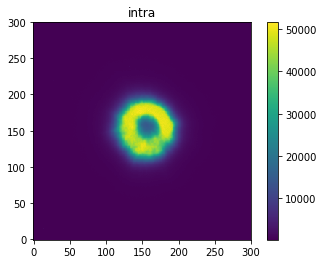

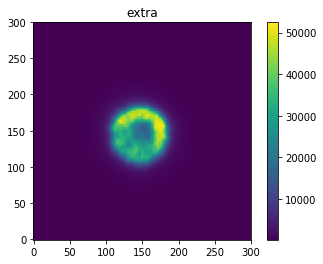

Extra-focal filename: 1579925882-16Pup_extra-0-1.fits
Intra-focal filename: 1579925833-16Pup_intra-0-1.fits


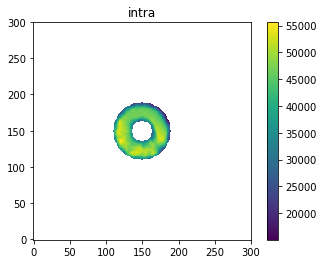

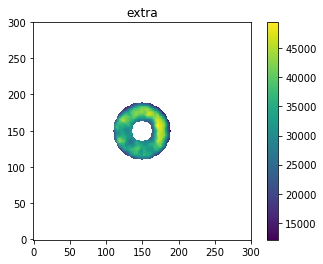

[ -2.64834353  21.22908288  27.1792713   28.6581697   -6.04139282
 -34.4072464  -15.52728688  -7.10915127  -1.75758141   5.1863813
 -12.22633069  -2.66191832   7.1892275    1.29093756   5.78417593
   3.72672155  -5.17603088   2.16955012  -0.8476196 ]


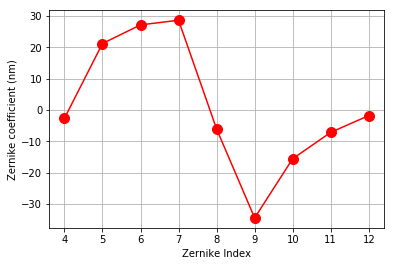

RemoteEvent(GenericCamera, 1, logMessage) falling behind; read 84 messages


Waiting intra image


RemoteEvent(GenericCamera, 1, heartbeat) falling behind; read 76 messages


1579926008-16Pup_intra-0-1
1579926057-16Pup_extra-0-1
1579926008-16Pup_intra-0-1.fits
1579926057-16Pup_extra-0-1.fits
4 3
Creating stamps of centroid [y,x] = [329,548] with a side length of 150 pixels
Offset should be :20.5 [mm] at the focus, 0.5 [mm] at the hexapod
Offset in file is :28.7 [mm] at the focus
pixelSize should be: 1.44e-05


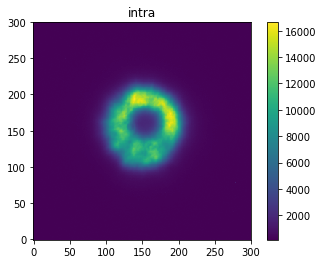

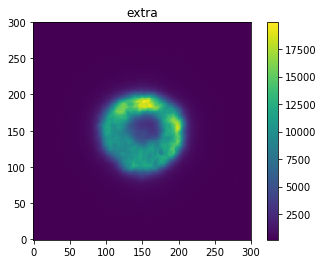

Extra-focal filename: 1579926057-16Pup_extra-0-1.fits
Intra-focal filename: 1579926008-16Pup_intra-0-1.fits


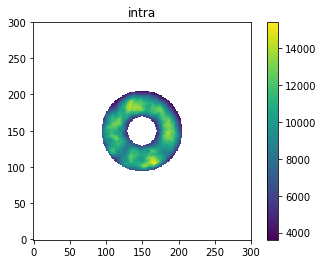

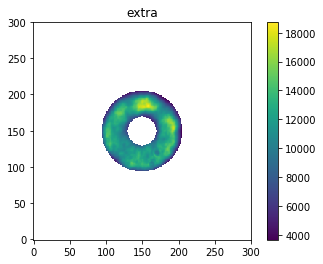

[ 8.20979277e+01 -9.09029016e+01  1.62136865e+02  5.25805177e+01
  1.55627473e+01 -4.10449072e+01 -1.72548855e+01 -5.93033266e+00
  9.33043114e+00  1.23381886e+01 -3.98803109e+00 -2.03406964e+01
  7.17124120e+00  3.94174735e+00  9.39489502e+00 -9.63563627e-02
  4.77453513e+00 -7.08476781e+00 -2.77550344e+00]


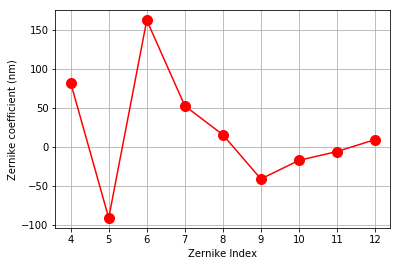

RemoteEvent(GenericCamera, 1, logMessage) falling behind; read 54 messages


Waiting intra image


RemoteEvent(GenericCamera, 1, heartbeat) falling behind; read 75 messages


1579926150-16Pup_intra-0-1
1579926201-16Pup_extra-0-1
1579926150-16Pup_intra-0-1.fits
1579926201-16Pup_extra-0-1.fits


TypeError: buffer is too small for requested array

In [9]:
for i in range(6):
    print("================================================================================")
    print("Waiting intra image")
    cam.evt_endReadout.flush()
    intra_endron = await cam.evt_endReadout.next(flush=False)
    if "intra" not in intra_endron.imageName:
        print(f"Got {intra_endron.imageName}. Not an intra image... skipping")
        continue
    print(intra_endron.imageName)

    extra_endron = await cam.evt_endReadout.next(flush=False, timeout=120)
    print(extra_endron.imageName)

    intra_wget_url = 'http://139.229.170.216:8000/data/'+intra_endron.imageName+'.fits'
    extra_wget_url = 'http://139.229.170.216:8000/data/'+extra_endron.imageName+'.fits'
    download_done = False
    while not download_done:
        try:
            intra_fname = wget.download(intra_wget_url)
        except Exception as e:
            print(f"Error downloading {intra_wget_url}. waiting 5s and trying again.")
            await asyncio.sleep(5.)
        else:
            download_done = True
    print(f"============")
    print(f'{intra_fname}')

    download_done = False
    while not download_done:
        try:
            extra_fname = wget.download(extra_wget_url)
        except Exception as e:
            print(f"Error downloading {intra_wget_url}. waiting 5s and trying again.")
            await asyncio.sleep(5.)
        else:
            download_done = True
            
    print(f'{extra_fname}')
    print(f"============")

    # Open fits files, note you can start here if your files exist already

    #intra_fname='I1_intra_20190908.fits'
    intra_exp=(fits.open(intra_fname))[0].data

    #extra_fname='I2_extra_20190908.fits'
    extra_exp=(fits.open(extra_fname))[0].data

    # Show images added together to estimate centroid
    plt.imshow(intra_exp+extra_exp)

    # Define the image it will use to perform final center
    im_shape=intra_exp.shape
    side=300
    # Set to False to declare centroid manually!
    if True:
        im= (intra_exp+extra_exp)
        im_filtered = medfilt(im,[5,5])
        im_filtered -= int(np.median(im_filtered))
        mean = np.mean(im_filtered)
    #     im_filtered[im_filtered < mean] = 0.
    #     im_filtered[im_filtered > mean] = 1.
        # iter 1
        ceny, cenx = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
        # iter 2
        intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
        extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]
        im= (intra_square+extra_square)
        im_filtered = medfilt(im,[5,5])
        im_filtered -= int(np.median(im_filtered))
        mean = np.mean(im_filtered)
        im_filtered[im_filtered < mean] = 0.
        im_filtered[im_filtered > mean] = 1.
        # iter 1
        cy2, cx2 = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
        print(cy2-side, cx2-side)    
        ceny += (cy2-side)
        cenx += (cx2-side)
    else:
        # Manually declare where the center is
        ceny=350 #round(im_shape[0]/2)
        cenx=450 # round(im_shape[1]/2)
    side=150 # side length of image
    print('Creating stamps of centroid [y,x] = [{},{}] with a side length of {} pixels'.format(ceny,cenx,side))
    im_shape=intra_exp.shape
    intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
    extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]

    #Create object for CWFS code
    # Select where your object is, but ours will be on-axis
    fieldXY = [0.0,0.0]

    # I1/I2 get modified down below, so reset here
    I1 = None; I2=None
    I1 = Image(intra_square, fieldXY, Image.INTRA)
    I2 = Image(extra_square, fieldXY, Image.EXTRA)

    # Declare instrument
    inst=Instrument(f'auxtel_{i+1}',I1.sizeinPix) # example
    hex_to_focus_scale = 41.0
    offset=0.5 *hex_to_focus_scale # [mm] multiply hexapod dz by magnification factor
    pixelsize = 3.6e-6*4 # 4 is the binning
    # FIXME: put an assertion here and calculate binning above based on change in image size, also pull offset from filename!

    print('Offset should be :{} [mm] at the focus, {} [mm] at the hexapod'.format(offset, offset/hex_to_focus_scale))
    print('Offset in file is :{} [mm] at the focus'.format(1e3*inst.offset))
    print('pixelSize should be: {}'.format(pixelsize))

    #declare algorithm
    # declare algorithm - exponential solver.
    algo=Algorithm('exp',inst,1) # example - but only want 11 Zernikes (Num_of_Zernikes)


    # Plot images
    plots.plotImage(I1.image,'intra') 
    #plots.plotImage(I_focus.image,'focus')
    plots.plotImage(I2.image,'extra')
    print('Extra-focal filename: {}'.format(extra_fname))
    print('Intra-focal filename: {}'.format(intra_fname))

    algo.runIt(inst,I1,I2,'onAxis')
    plots.plotImage(I1.image,'intra', mask=algo.pMask) 
    #plots.plotImage(I_focus.image,'focus')
    plots.plotImage(I2.image,'extra', mask=algo.pMask)    
    print(algo.zer4UpNm)
    plots.plotZer(algo.zer4UpNm[0:9],'nm')
    zern.append(algo.zer4UpNm[0:9])

In [28]:
stoped_at = i

1579926150-16Pup_intra-0-1 (1).fits
1579926201-16Pup_extra-0-1 (1).fits
2 0
Creating stamps of centroid [y,x] = [307,530] with a side length of 150 pixels
Offset should be :20.5 [mm] at the focus, 0.5 [mm] at the hexapod
Offset in file is :36.900000000000006 [mm] at the focus
pixelSize should be: 1.44e-05


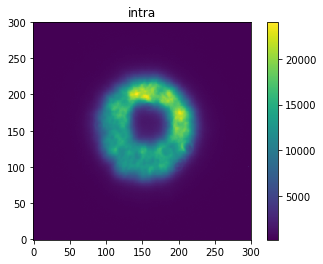

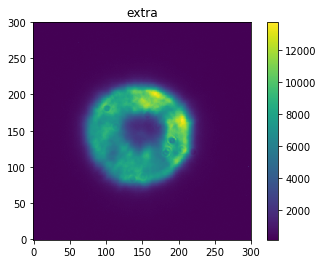

Extra-focal filename: 1579926201-16Pup_extra-0-1 (1).fits
Intra-focal filename: 1579926150-16Pup_intra-0-1 (1).fits


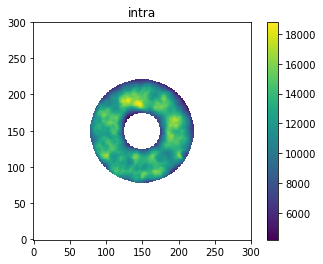

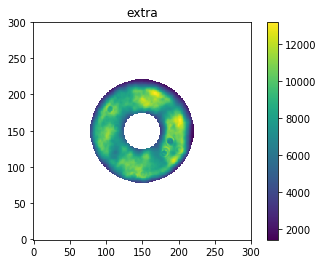

[ 1.17332166e+02 -3.82114451e+01  2.00900289e+02  7.61395737e+01
  5.13052158e+01 -3.76829826e+01 -2.60862185e+01  1.59748204e+01
 -3.50165531e-02 -2.70167462e+00  3.05934865e-01 -1.61354706e+01
  1.32729846e+00 -6.24004276e-01  8.72583331e+00 -6.88829543e-01
 -1.40207685e+01 -6.03379198e+00 -1.08575733e+01]


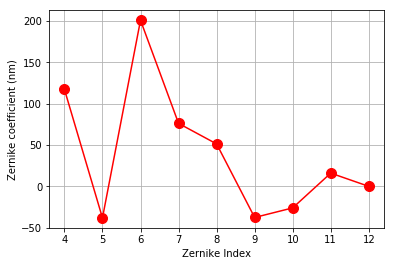

RemoteEvent(GenericCamera, 1, heartbeat) falling behind; read 78 messages


In [12]:
intra_wget_url = 'http://139.229.170.216:8000/data/'+intra_endron.imageName+'.fits'
extra_wget_url = 'http://139.229.170.216:8000/data/'+extra_endron.imageName+'.fits'
download_done = False
while not download_done:
    try:
        intra_fname = wget.download(intra_wget_url)
    except Exception as e:
        print(f"Error downloading {intra_wget_url}. waiting 5s and trying again.")
        await asyncio.sleep(5.)
    else:
        download_done = True
print(f"============")
print(f'{intra_fname}')

download_done = False
while not download_done:
    try:
        extra_fname = wget.download(extra_wget_url)
    except Exception as e:
        print(f"Error downloading {intra_wget_url}. waiting 5s and trying again.")
        await asyncio.sleep(5.)
    else:
        download_done = True

print(f'{extra_fname}')
print(f"============")

# Open fits files, note you can start here if your files exist already

#intra_fname='I1_intra_20190908.fits'
intra_exp=(fits.open(intra_fname))[0].data

#extra_fname='I2_extra_20190908.fits'
extra_exp=(fits.open(extra_fname))[0].data

# Show images added together to estimate centroid
plt.imshow(intra_exp+extra_exp)

# Define the image it will use to perform final center
im_shape=intra_exp.shape
side=300
# Set to False to declare centroid manually!
if True:
    im= (intra_exp+extra_exp)
    im_filtered = medfilt(im,[5,5])
    im_filtered -= int(np.median(im_filtered))
    mean = np.mean(im_filtered)
#     im_filtered[im_filtered < mean] = 0.
#     im_filtered[im_filtered > mean] = 1.
    # iter 1
    ceny, cenx = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
    # iter 2
    intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
    extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]
    im= (intra_square+extra_square)
    im_filtered = medfilt(im,[5,5])
    im_filtered -= int(np.median(im_filtered))
    mean = np.mean(im_filtered)
    im_filtered[im_filtered < mean] = 0.
    im_filtered[im_filtered > mean] = 1.
    # iter 1
    cy2, cx2 = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
    print(cy2-side, cx2-side)    
    ceny += (cy2-side)
    cenx += (cx2-side)
else:
    # Manually declare where the center is
    ceny=350 #round(im_shape[0]/2)
    cenx=450 # round(im_shape[1]/2)
side=150 # side length of image
print('Creating stamps of centroid [y,x] = [{},{}] with a side length of {} pixels'.format(ceny,cenx,side))
im_shape=intra_exp.shape
intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]

#Create object for CWFS code
# Select where your object is, but ours will be on-axis
fieldXY = [0.0,0.0]

# I1/I2 get modified down below, so reset here
I1 = None; I2=None
I1 = Image(intra_square, fieldXY, Image.INTRA)
I2 = Image(extra_square, fieldXY, Image.EXTRA)

# Declare instrument
inst=Instrument(f'auxtel_{i+1}',I1.sizeinPix) # example
hex_to_focus_scale = 41.0
offset=0.5 *hex_to_focus_scale # [mm] multiply hexapod dz by magnification factor
pixelsize = 3.6e-6*4 # 4 is the binning
# FIXME: put an assertion here and calculate binning above based on change in image size, also pull offset from filename!

print('Offset should be :{} [mm] at the focus, {} [mm] at the hexapod'.format(offset, offset/hex_to_focus_scale))
print('Offset in file is :{} [mm] at the focus'.format(1e3*inst.offset))
print('pixelSize should be: {}'.format(pixelsize))

#declare algorithm
# declare algorithm - exponential solver.
algo=Algorithm('exp',inst,1) # example - but only want 11 Zernikes (Num_of_Zernikes)


# Plot images
plots.plotImage(I1.image,'intra') 
#plots.plotImage(I_focus.image,'focus')
plots.plotImage(I2.image,'extra')
print('Extra-focal filename: {}'.format(extra_fname))
print('Intra-focal filename: {}'.format(intra_fname))

algo.runIt(inst,I1,I2,'onAxis')
plots.plotImage(I1.image,'intra', mask=algo.pMask) 
#plots.plotImage(I_focus.image,'focus')
plots.plotImage(I2.image,'extra', mask=algo.pMask)    
print(algo.zer4UpNm)
plots.plotZer(algo.zer4UpNm[0:9],'nm')
zern.append(algo.zer4UpNm[0:9])

Waiting intra image
1579926455-16Pup_intra-0-1
1579926507-16Pup_extra-0-1
1579926455-16Pup_intra-0-1.fits
1579926507-16Pup_extra-0-1.fits
29 26
Creating stamps of centroid [y,x] = [347,538] with a side length of 150 pixels
Offset should be :20.5 [mm] at the focus, 0.5 [mm] at the hexapod
Offset in file is :45.1 [mm] at the focus
pixelSize should be: 1.44e-05


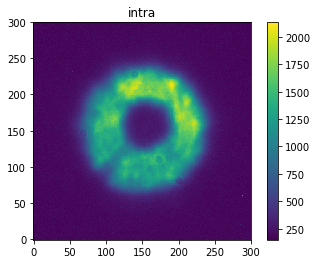

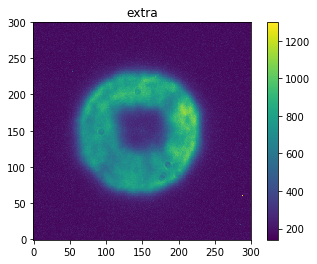

Extra-focal filename: 1579926507-16Pup_extra-0-1.fits
Intra-focal filename: 1579926455-16Pup_intra-0-1.fits


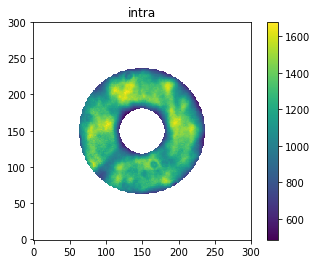

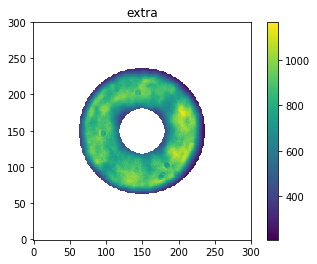

[112.54335249 -18.42063282  77.47929812  67.60795123  40.09362725
 -30.69074318   8.51766376  19.9105922   -1.7852782    7.37362677
 -25.48490886  -4.40286255   4.49472352  -0.235933     5.04451293
   1.7700671    2.77271786   5.25715765 -11.0458012 ]


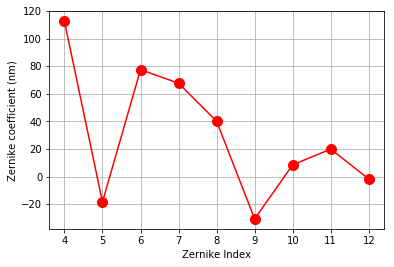

RemoteEvent(GenericCamera, 1, logMessage) falling behind; read 30 messages
RemoteEvent(GenericCamera, 1, heartbeat) falling behind; read 75 messages


Waiting intra image
1579926576-16Pup_intra-0-1
1579926630-16Pup_extra-0-1
1579926576-16Pup_intra-0-1.fits
1579926630-16Pup_extra-0-1.fits


/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: cannot convert float NaN to integer

In [13]:
for i in range(stoped_at+1, 6):
    print("================================================================================")
    print("Waiting intra image")
    cam.evt_endReadout.flush()
    intra_endron = await cam.evt_endReadout.next(flush=False)
    if "intra" not in intra_endron.imageName:
        print(f"Got {intra_endron.imageName}. Not an intra image... skipping")
        continue
    print(intra_endron.imageName)

    extra_endron = await cam.evt_endReadout.next(flush=False, timeout=120)
    print(extra_endron.imageName)

    intra_wget_url = 'http://139.229.170.216:8000/data/'+intra_endron.imageName+'.fits'
    extra_wget_url = 'http://139.229.170.216:8000/data/'+extra_endron.imageName+'.fits'
    download_done = False
    while not download_done:
        try:
            intra_fname = wget.download(intra_wget_url)
        except Exception as e:
            print(f"Error downloading {intra_wget_url}. waiting 5s and trying again.")
            await asyncio.sleep(5.)
        else:
            download_done = True
    print(f"============")
    print(f'{intra_fname}')

    download_done = False
    while not download_done:
        try:
            extra_fname = wget.download(extra_wget_url)
        except Exception as e:
            print(f"Error downloading {intra_wget_url}. waiting 5s and trying again.")
            await asyncio.sleep(5.)
        else:
            download_done = True
            
    print(f'{extra_fname}')
    print(f"============")

    # Open fits files, note you can start here if your files exist already

    #intra_fname='I1_intra_20190908.fits'
    intra_exp=(fits.open(intra_fname))[0].data

    #extra_fname='I2_extra_20190908.fits'
    extra_exp=(fits.open(extra_fname))[0].data

    # Show images added together to estimate centroid
    plt.imshow(intra_exp+extra_exp)

    # Define the image it will use to perform final center
    im_shape=intra_exp.shape
    side=300
    # Set to False to declare centroid manually!
    if True:
        im= (intra_exp+extra_exp)
        im_filtered = medfilt(im,[5,5])
        im_filtered -= int(np.median(im_filtered))
        mean = np.mean(im_filtered)
    #     im_filtered[im_filtered < mean] = 0.
    #     im_filtered[im_filtered > mean] = 1.
        # iter 1
        ceny, cenx = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
        # iter 2
        intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
        extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]
        im= (intra_square+extra_square)
        im_filtered = medfilt(im,[5,5])
        im_filtered -= int(np.median(im_filtered))
        mean = np.mean(im_filtered)
        im_filtered[im_filtered < mean] = 0.
        im_filtered[im_filtered > mean] = 1.
        # iter 1
        cy2, cx2 = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
        print(cy2-side, cx2-side)    
        ceny += (cy2-side)
        cenx += (cx2-side)
    else:
        # Manually declare where the center is
        ceny=350 #round(im_shape[0]/2)
        cenx=450 # round(im_shape[1]/2)
    side=150 # side length of image
    print('Creating stamps of centroid [y,x] = [{},{}] with a side length of {} pixels'.format(ceny,cenx,side))
    im_shape=intra_exp.shape
    intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
    extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]

    #Create object for CWFS code
    # Select where your object is, but ours will be on-axis
    fieldXY = [0.0,0.0]

    # I1/I2 get modified down below, so reset here
    I1 = None; I2=None
    I1 = Image(intra_square, fieldXY, Image.INTRA)
    I2 = Image(extra_square, fieldXY, Image.EXTRA)

    # Declare instrument
    inst=Instrument(f'auxtel_{i+1}',I1.sizeinPix) # example
    hex_to_focus_scale = 41.0
    offset=0.5 *hex_to_focus_scale # [mm] multiply hexapod dz by magnification factor
    pixelsize = 3.6e-6*4 # 4 is the binning
    # FIXME: put an assertion here and calculate binning above based on change in image size, also pull offset from filename!

    print('Offset should be :{} [mm] at the focus, {} [mm] at the hexapod'.format(offset, offset/hex_to_focus_scale))
    print('Offset in file is :{} [mm] at the focus'.format(1e3*inst.offset))
    print('pixelSize should be: {}'.format(pixelsize))

    #declare algorithm
    # declare algorithm - exponential solver.
    algo=Algorithm('exp',inst,1) # example - but only want 11 Zernikes (Num_of_Zernikes)


    # Plot images
    plots.plotImage(I1.image,'intra') 
    #plots.plotImage(I_focus.image,'focus')
    plots.plotImage(I2.image,'extra')
    print('Extra-focal filename: {}'.format(extra_fname))
    print('Intra-focal filename: {}'.format(intra_fname))

    algo.runIt(inst,I1,I2,'onAxis')
    plots.plotImage(I1.image,'intra', mask=algo.pMask) 
    #plots.plotImage(I_focus.image,'focus')
    plots.plotImage(I2.image,'extra', mask=algo.pMask)    
    print(algo.zer4UpNm)
    plots.plotZer(algo.zer4UpNm[0:9],'nm')
    zern.append(algo.zer4UpNm[0:9])

nan


ValueError: cannot convert float NaN to integer

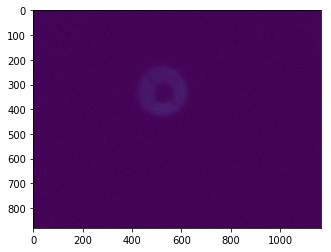

In [27]:
# intra_wget_url = 'http://139.229.170.216:8000/data/'+intra_endron.imageName+'.fits'
# extra_wget_url = 'http://139.229.170.216:8000/data/'+extra_endron.imageName+'.fits'
# download_done = False
# while not download_done:
#     try:
#         intra_fname = wget.download(intra_wget_url)
#     except Exception as e:
#         print(f"Error downloading {intra_wget_url}. waiting 5s and trying again.")
#         await asyncio.sleep(5.)
#     else:
#         download_done = True
# print(f"============")
# print(f'{intra_fname}')

# download_done = False
# while not download_done:
#     try:
#         extra_fname = wget.download(extra_wget_url)
#     except Exception as e:
#         print(f"Error downloading {intra_wget_url}. waiting 5s and trying again.")
#         await asyncio.sleep(5.)
#     else:
#         download_done = True

# print(f'{extra_fname}')
# print(f"============")

# Open fits files, note you can start here if your files exist already

#intra_fname='I1_intra_20190908.fits'
intra_exp=(fits.open(intra_fname))[0].data

#extra_fname='I2_extra_20190908.fits'
extra_exp=(fits.open(extra_fname))[0].data

# Show images added together to estimate centroid
plt.imshow(intra_exp+extra_exp)

# Define the image it will use to perform final center
im_shape=intra_exp.shape
side=250
# Set to False to declare centroid manually!
if True:
    im= (intra_exp+extra_exp)
    im_filtered = medfilt(im,[5,5])
    im_filtered -= int(np.median(im_filtered))
    mean = np.mean(im_filtered)
#     im_filtered[im_filtered < mean] = 0.
#     im_filtered[im_filtered > mean] = 1.
    # iter 1
    ceny, cenx = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
    # iter 2
    intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
    extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]
    im= (intra_square+extra_square)
    im_filtered = im # medfilt(im,[3,3])
    print(np.median(im))
    im_filtered -= int(np.median(im_filtered))
    mean = np.mean(im_filtered[im_filtered>0])
    im_filtered[im_filtered < mean] = 0.
    im_filtered[im_filtered > mean] = 1.
    # iter 1
    cy2, cx2 = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
    print(cy2-side, cx2-side)    
    ceny += (cy2-side)
    cenx += (cx2-side)
else:
    # Manually declare where the center is
    ceny=350 #round(im_shape[0]/2)
    cenx=450 # round(im_shape[1]/2)
side=150 # side length of image
print('Creating stamps of centroid [y,x] = [{},{}] with a side length of {} pixels'.format(ceny,cenx,side))
im_shape=intra_exp.shape
intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]

#Create object for CWFS code
# Select where your object is, but ours will be on-axis
fieldXY = [0.0,0.0]

# I1/I2 get modified down below, so reset here
I1 = None; I2=None
I1 = Image(intra_square, fieldXY, Image.INTRA)
I2 = Image(extra_square, fieldXY, Image.EXTRA)

# Declare instrument
inst=Instrument(f'auxtel_{i+1}',I1.sizeinPix) # example
hex_to_focus_scale = 41.0
offset=0.5 *hex_to_focus_scale # [mm] multiply hexapod dz by magnification factor
pixelsize = 3.6e-6*4 # 4 is the binning
# FIXME: put an assertion here and calculate binning above based on change in image size, also pull offset from filename!

print('Offset should be :{} [mm] at the focus, {} [mm] at the hexapod'.format(offset, offset/hex_to_focus_scale))
print('Offset in file is :{} [mm] at the focus'.format(1e3*inst.offset))
print('pixelSize should be: {}'.format(pixelsize))

#declare algorithm
# declare algorithm - exponential solver.
algo=Algorithm('exp',inst,1) # example - but only want 11 Zernikes (Num_of_Zernikes)


# Plot images
plots.plotImage(I1.image,'intra') 
#plots.plotImage(I_focus.image,'focus')
plots.plotImage(I2.image,'extra')
print('Extra-focal filename: {}'.format(extra_fname))
print('Intra-focal filename: {}'.format(intra_fname))

algo.runIt(inst,I1,I2,'onAxis')
plots.plotImage(I1.image,'intra', mask=algo.pMask) 
#plots.plotImage(I_focus.image,'focus')
plots.plotImage(I2.image,'extra', mask=algo.pMask)    
print(algo.zer4UpNm)
plots.plotZer(algo.zer4UpNm[0:9],'nm')
zern.append(algo.zer4UpNm[0:9])

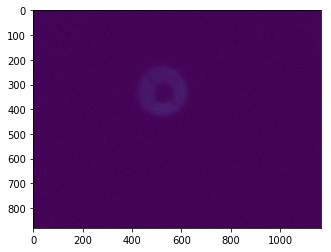

In [15]:
plt.imshow(intra_exp+extra_exp)

In [20]:
np.any(extra_exp == np.nan)

False

In [29]:
for i in range(stoped_at+1, 6):
    print("================================================================================")
    print("Waiting intra image")
    cam.evt_endReadout.flush()
    intra_endron = await cam.evt_endReadout.next(flush=False)
    if "intra" not in intra_endron.imageName:
        print(f"Got {intra_endron.imageName}. Not an intra image... skipping")
        continue
    print(intra_endron.imageName)

    extra_endron = await cam.evt_endReadout.next(flush=False, timeout=120)
    print(extra_endron.imageName)

    intra_wget_url = 'http://139.229.170.216:8000/data/'+intra_endron.imageName+'.fits'
    extra_wget_url = 'http://139.229.170.216:8000/data/'+extra_endron.imageName+'.fits'
    download_done = False
    while not download_done:
        try:
            intra_fname = wget.download(intra_wget_url)
        except Exception as e:
            print(f"Error downloading {intra_wget_url}. waiting 5s and trying again.")
            await asyncio.sleep(5.)
        else:
            download_done = True
    print(f"============")
    print(f'{intra_fname}')

    download_done = False
    while not download_done:
        try:
            extra_fname = wget.download(extra_wget_url)
        except Exception as e:
            print(f"Error downloading {intra_wget_url}. waiting 5s and trying again.")
            await asyncio.sleep(5.)
        else:
            download_done = True
            
    print(f'{extra_fname}')
    print(f"============")

    # Open fits files, note you can start here if your files exist already

    #intra_fname='I1_intra_20190908.fits'
    intra_exp=(fits.open(intra_fname))[0].data

    #extra_fname='I2_extra_20190908.fits'
    extra_exp=(fits.open(extra_fname))[0].data

    # Show images added together to estimate centroid
    plt.imshow(intra_exp+extra_exp)

    # Define the image it will use to perform final center
    im_shape=intra_exp.shape
    side=300
    # Set to False to declare centroid manually!
    if True:
        im= (intra_exp+extra_exp)
        im_filtered = medfilt(im,[5,5])
        im_filtered -= int(np.median(im_filtered))
        mean = np.mean(im_filtered)
    #     im_filtered[im_filtered < mean] = 0.
    #     im_filtered[im_filtered > mean] = 1.
        # iter 1
        ceny, cenx = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
        # iter 2
        intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
        extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]
        im= (intra_square+extra_square)
        im_filtered = medfilt(im,[5,5])
        im_filtered -= int(np.median(im_filtered))
        mean = np.mean(im_filtered)
        im_filtered[im_filtered < mean] = 0.
        im_filtered[im_filtered > mean] = 1.
        # iter 1
        cy2, cx2 = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
        print(cy2-side, cx2-side)    
        ceny += (cy2-side)
        cenx += (cx2-side)
    else:
        # Manually declare where the center is
        ceny=350 #round(im_shape[0]/2)
        cenx=450 # round(im_shape[1]/2)
    side=150 # side length of image
    print('Creating stamps of centroid [y,x] = [{},{}] with a side length of {} pixels'.format(ceny,cenx,side))
    im_shape=intra_exp.shape
    intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
    extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]

    #Create object for CWFS code
    # Select where your object is, but ours will be on-axis
    fieldXY = [0.0,0.0]

    # I1/I2 get modified down below, so reset here
    I1 = None; I2=None
    I1 = Image(intra_square, fieldXY, Image.INTRA)
    I2 = Image(extra_square, fieldXY, Image.EXTRA)

    # Declare instrument
    inst=Instrument(f'auxtel_{i+1}',I1.sizeinPix) # example
    hex_to_focus_scale = 41.0
    offset=0.5 *hex_to_focus_scale # [mm] multiply hexapod dz by magnification factor
    pixelsize = 3.6e-6*4 # 4 is the binning
    # FIXME: put an assertion here and calculate binning above based on change in image size, also pull offset from filename!

    print('Offset should be :{} [mm] at the focus, {} [mm] at the hexapod'.format(offset, offset/hex_to_focus_scale))
    print('Offset in file is :{} [mm] at the focus'.format(1e3*inst.offset))
    print('pixelSize should be: {}'.format(pixelsize))

    #declare algorithm
    # declare algorithm - exponential solver.
    algo=Algorithm('exp',inst,1) # example - but only want 11 Zernikes (Num_of_Zernikes)


    # Plot images
    plots.plotImage(I1.image,'intra') 
    #plots.plotImage(I_focus.image,'focus')
    plots.plotImage(I2.image,'extra')
    print('Extra-focal filename: {}'.format(extra_fname))
    print('Intra-focal filename: {}'.format(intra_fname))

    algo.runIt(inst,I1,I2,'onAxis')
    plots.plotImage(I1.image,'intra', mask=algo.pMask) 
    #plots.plotImage(I_focus.image,'focus')
    plots.plotImage(I2.image,'extra', mask=algo.pMask)    
    print(algo.zer4UpNm)
    plots.plotZer(algo.zer4UpNm[0:9],'nm')
    zern.append(algo.zer4UpNm[0:9])

Waiting intra image
1579927046-16Pup_intra-0-1
1579927100-16Pup_extra-0-1
1579927046-16Pup_intra-0-1.fits
Error downloading http://139.229.170.216:8000/data/1579927046-16Pup_intra-0-1.fits. waiting 5s and trying again.
1579927100-16Pup_extra-0-1.fits
39 31
Creating stamps of centroid [y,x] = [429,646] with a side length of 150 pixels


FileNotFoundError: [Errno 2] No such file or directory: '/home/saluser/develop/cwfs/python/lsst/cwfs/../../../data/auxtel_6/auxtel_6.param'

39 31
Creating stamps of centroid [y,x] = [429,646] with a side length of 150 pixels
Offset should be :20.5 [mm] at the focus, 0.5 [mm] at the hexapod
Offset in file is :61.5 [mm] at the focus
pixelSize should be: 1.44e-05


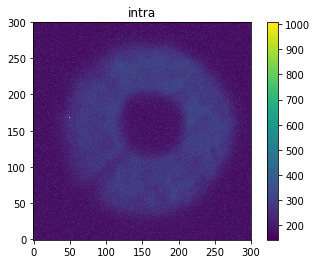

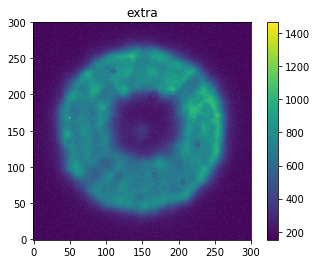

Extra-focal filename: 1579927100-16Pup_extra-0-1.fits
Intra-focal filename: 1579927046-16Pup_intra-0-1.fits


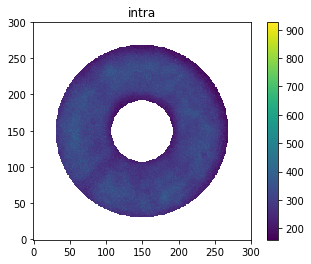

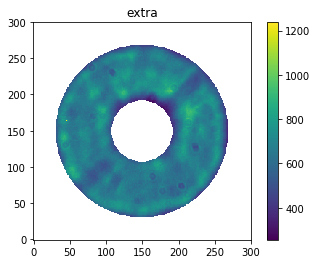

[-48.93034443 -52.13178703  89.99466082  22.16169854   6.9676877
 -27.25831684 -45.8188886  -60.53806183  -9.41068775   0.89463988
   6.99354136  -1.38457881  11.96778897   8.35298597   5.06801391
   3.4879277   -0.64014681  -7.78975631   8.66839652]


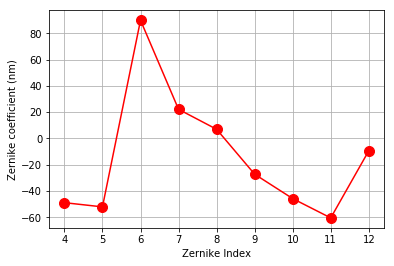

RemoteEvent(GenericCamera, 1, heartbeat) falling behind; read 77 messages


In [31]:
# intra_wget_url = 'http://139.229.170.216:8000/data/'+intra_endron.imageName+'.fits'
# extra_wget_url = 'http://139.229.170.216:8000/data/'+extra_endron.imageName+'.fits'
# download_done = False
# while not download_done:
#     try:
#         intra_fname = wget.download(intra_wget_url)
#     except Exception as e:
#         print(f"Error downloading {intra_wget_url}. waiting 5s and trying again.")
#         await asyncio.sleep(5.)
#     else:
#         download_done = True
# print(f"============")
# print(f'{intra_fname}')

# download_done = False
# while not download_done:
#     try:
#         extra_fname = wget.download(extra_wget_url)
#     except Exception as e:
#         print(f"Error downloading {intra_wget_url}. waiting 5s and trying again.")
#         await asyncio.sleep(5.)
#     else:
#         download_done = True

# print(f'{extra_fname}')
# print(f"============")

# Open fits files, note you can start here if your files exist already

#intra_fname='I1_intra_20190908.fits'
intra_exp=(fits.open(intra_fname))[0].data

#extra_fname='I2_extra_20190908.fits'
extra_exp=(fits.open(extra_fname))[0].data

# Show images added together to estimate centroid
plt.imshow(intra_exp+extra_exp)

# Define the image it will use to perform final center
im_shape=intra_exp.shape
side=300
# Set to False to declare centroid manually!
if True:
    im= (intra_exp+extra_exp)
    im_filtered = medfilt(im,[5,5])
    im_filtered -= int(np.median(im_filtered))
    mean = np.mean(im_filtered)
#     im_filtered[im_filtered < mean] = 0.
#     im_filtered[im_filtered > mean] = 1.
    # iter 1
    ceny, cenx = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
    # iter 2
    intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
    extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]
    im= (intra_square+extra_square)
    im_filtered = medfilt(im,[5,5])
    im_filtered -= int(np.median(im_filtered))
    mean = np.mean(im_filtered[im_filtered>0])
    im_filtered[im_filtered < mean] = 0.
    im_filtered[im_filtered > mean] = 1.
    # iter 1
    cy2, cx2 = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
    print(cy2-side, cx2-side)    
    ceny += (cy2-side)
    cenx += (cx2-side)
else:
    # Manually declare where the center is
    ceny=350 #round(im_shape[0]/2)
    cenx=450 # round(im_shape[1]/2)
side=150 # side length of image
print('Creating stamps of centroid [y,x] = [{},{}] with a side length of {} pixels'.format(ceny,cenx,side))
im_shape=intra_exp.shape
intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]

#Create object for CWFS code
# Select where your object is, but ours will be on-axis
fieldXY = [0.0,0.0]

# I1/I2 get modified down below, so reset here
I1 = None; I2=None
I1 = Image(intra_square, fieldXY, Image.INTRA)
I2 = Image(extra_square, fieldXY, Image.EXTRA)

# Declare instrument
inst=Instrument(f'auxtel_{i+1}',I1.sizeinPix) # example
hex_to_focus_scale = 41.0
offset=0.5 *hex_to_focus_scale # [mm] multiply hexapod dz by magnification factor
pixelsize = 3.6e-6*4 # 4 is the binning
# FIXME: put an assertion here and calculate binning above based on change in image size, also pull offset from filename!

print('Offset should be :{} [mm] at the focus, {} [mm] at the hexapod'.format(offset, offset/hex_to_focus_scale))
print('Offset in file is :{} [mm] at the focus'.format(1e3*inst.offset))
print('pixelSize should be: {}'.format(pixelsize))

#declare algorithm
# declare algorithm - exponential solver.
algo=Algorithm('exp',inst,1) # example - but only want 11 Zernikes (Num_of_Zernikes)


# Plot images
plots.plotImage(I1.image,'intra') 
#plots.plotImage(I_focus.image,'focus')
plots.plotImage(I2.image,'extra')
print('Extra-focal filename: {}'.format(extra_fname))
print('Intra-focal filename: {}'.format(intra_fname))

algo.runIt(inst,I1,I2,'onAxis')
plots.plotImage(I1.image,'intra', mask=algo.pMask) 
#plots.plotImage(I_focus.image,'focus')
plots.plotImage(I2.image,'extra', mask=algo.pMask)    
print(algo.zer4UpNm)
plots.plotZer(algo.zer4UpNm[0:9],'nm')
zern.append(algo.zer4UpNm[0:9])

In [32]:
zern

[array([-191.40271886,   87.37068443,   16.01153738,   14.75869529,
          11.8456627 ,  -33.90329815,   17.77569872,   13.00752371,
          -0.74032462]),
 array([ 11.67343028,  69.18526159,  77.06704462,  49.71408814,
         37.03258309, -21.69946966,  -8.27806142,   8.16894308,
         -3.39368404]),
 array([-104.47770891,   40.40196124,   43.61351577,  -25.83492204,
         -40.39759588,   25.80071769,  -46.20048213,   42.74478287,
           5.36188782]),
 array([  37.58205147,   80.38980457,  221.39801727, -260.6455648 ,
        -150.94971369,   85.39762426,   73.03991867,    7.65003306,
         -17.67374435]),
 array([ -2.64834353,  21.22908288,  27.1792713 ,  28.6581697 ,
         -6.04139282, -34.4072464 , -15.52728688,  -7.10915127,
         -1.75758141]),
 array([ 82.0979277 , -90.90290156, 162.13686541,  52.58051766,
         15.56274729, -41.04490725, -17.25488554,  -5.93033266,
          9.33043114]),
 array([ 1.17332166e+02, -3.82114451e+01,  2.00900289e+02,  7

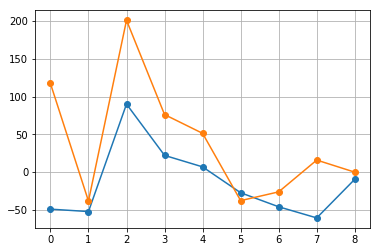

In [38]:
plt.plot(zern[-1], 'o-')
plt.plot(zern[-3], 'o-')
plt.grid()

In [ ]:
for i in range(stoped_at+1, 6):
    print("================================================================================")
    print("Waiting intra image")
    cam.evt_endReadout.flush()
    intra_endron = await cam.evt_endReadout.next(flush=False)
    if "intra" not in intra_endron.imageName:
        print(f"Got {intra_endron.imageName}. Not an intra image... skipping")
        continue
    print(intra_endron.imageName)

    extra_endron = await cam.evt_endReadout.next(flush=False, timeout=120)
    print(extra_endron.imageName)

    intra_wget_url = 'http://139.229.170.216:8000/data/'+intra_endron.imageName+'.fits'
    extra_wget_url = 'http://139.229.170.216:8000/data/'+extra_endron.imageName+'.fits'
    download_done = False
    while not download_done:
        try:
            intra_fname = wget.download(intra_wget_url)
        except Exception as e:
            print(f"Error downloading {intra_wget_url}. waiting 5s and trying again.")
            await asyncio.sleep(5.)
        else:
            download_done = True
    print(f"============")
    print(f'{intra_fname}')

    download_done = False
    while not download_done:
        try:
            extra_fname = wget.download(extra_wget_url)
        except Exception as e:
            print(f"Error downloading {intra_wget_url}. waiting 5s and trying again.")
            await asyncio.sleep(5.)
        else:
            download_done = True
            
    print(f'{extra_fname}')
    print(f"============")

    # Open fits files, note you can start here if your files exist already

    #intra_fname='I1_intra_20190908.fits'
    intra_exp=(fits.open(intra_fname))[0].data

    #extra_fname='I2_extra_20190908.fits'
    extra_exp=(fits.open(extra_fname))[0].data

    # Show images added together to estimate centroid
    plt.imshow(intra_exp+extra_exp)

    # Define the image it will use to perform final center
    im_shape=intra_exp.shape
    side=300
    # Set to False to declare centroid manually!
    if True:
        im= (intra_exp+extra_exp)
        im_filtered = medfilt(im,[5,5])
        im_filtered -= int(np.median(im_filtered))
        mean = np.mean(im_filtered)
    #     im_filtered[im_filtered < mean] = 0.
    #     im_filtered[im_filtered > mean] = 1.
        # iter 1
        ceny, cenx = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
        # iter 2
        intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
        extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]
        im= (intra_square+extra_square)
        im_filtered = medfilt(im,[5,5])
        im_filtered -= int(np.median(im_filtered))
        mean = np.mean(im_filtered)
        im_filtered[im_filtered < mean] = 0.
        im_filtered[im_filtered > mean] = 1.
        # iter 1
        cy2, cx2 = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
        print(cy2-side, cx2-side)    
        ceny += (cy2-side)
        cenx += (cx2-side)
    else:
        # Manually declare where the center is
        ceny=350 #round(im_shape[0]/2)
        cenx=450 # round(im_shape[1]/2)
    side=150 # side length of image
    print('Creating stamps of centroid [y,x] = [{},{}] with a side length of {} pixels'.format(ceny,cenx,side))
    im_shape=intra_exp.shape
    intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
    extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]

    #Create object for CWFS code
    # Select where your object is, but ours will be on-axis
    fieldXY = [0.0,0.0]

    # I1/I2 get modified down below, so reset here
    I1 = None; I2=None
    I1 = Image(intra_square, fieldXY, Image.INTRA)
    I2 = Image(extra_square, fieldXY, Image.EXTRA)

    # Declare instrument
    inst=Instrument(f'auxtel_{i+1}',I1.sizeinPix) # example
    hex_to_focus_scale = 41.0
    offset=0.5 *hex_to_focus_scale # [mm] multiply hexapod dz by magnification factor
    pixelsize = 3.6e-6*4 # 4 is the binning
    # FIXME: put an assertion here and calculate binning above based on change in image size, also pull offset from filename!

    print('Offset should be :{} [mm] at the focus, {} [mm] at the hexapod'.format(offset, offset/hex_to_focus_scale))
    print('Offset in file is :{} [mm] at the focus'.format(1e3*inst.offset))
    print('pixelSize should be: {}'.format(pixelsize))

    #declare algorithm
    # declare algorithm - exponential solver.
    algo=Algorithm('exp',inst,1) # example - but only want 11 Zernikes (Num_of_Zernikes)


    # Plot images
    plots.plotImage(I1.image,'intra') 
    #plots.plotImage(I_focus.image,'focus')
    plots.plotImage(I2.image,'extra')
    print('Extra-focal filename: {}'.format(extra_fname))
    print('Intra-focal filename: {}'.format(intra_fname))

    algo.runIt(inst,I1,I2,'onAxis')
    plots.plotImage(I1.image,'intra', mask=algo.pMask) 
    #plots.plotImage(I_focus.image,'focus')
    plots.plotImage(I2.image,'extra', mask=algo.pMask)    
    print(algo.zer4UpNm)
    plots.plotZer(algo.zer4UpNm[0:9],'nm')
    zern.append(algo.zer4UpNm[0:9])